# Menu <a class="anchor" id="menu"></a>

* [1. Préparatifs pour les algorithmes non-supervisés](#setup)

# Le data-drift

**TODO**

---
# Préparatifs 

In [1]:
import os
# import re
# import time
# import math
# import string
import datetime
# import unicodedata
# import json
from zipfile import ZipFile
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

random_seed = 0
np.random.seed(random_seed)
cmap_ref = 'nipy_spectral'

# import gc
# gc.enable()

In [2]:
data_customer = pd.read_csv(os.path.join('data', "olist_customers_dataset_clean.csv"))
data_orders = pd.read_csv(os.path.join('data', "olist_orders_dataset_clean.csv"))
data_items = pd.read_csv(os.path.join('data', "olist_order_items_dataset_clean.csv"))
data_payments = pd.read_csv(os.path.join('data', "olist_order_payments_dataset_clean.csv"))
data_reviews = pd.read_csv(os.path.join('data', "olist_order_reviews_dataset_clean.csv"))

---
---
# 1. Définition des fonctions génériques <a class="anchor" id="functions"></a> [⇪](#menu)

## 1.1 Feature Engineering <a class="anchor" id="functions_fe"></a> [⇪](#menu)

In [3]:
def str_to_date(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

def prepare_data(since, until, verbose=0):

    # Select the delivered orders using the provided purchase date range

    if(verbose > 0):
        print(f"\nSelection des commandes passées entre {since} et {until}")

    selection1 = data_orders[
        (data_orders.order_purchase_timestamp >= since) & 
        (data_orders.order_purchase_timestamp < until) & 
        (data_orders.order_status == 'delivered')][['order_id', 'customer_id', 'order_purchase_timestamp']]

    if(verbose > 1):
        display(selection1.head(2))
        display(selection1.shape)

    # Add the `customer_unique_id` using the temporary `customer_id`
    if(verbose > 0):
        print("\nAjout des ID unique des clients")

    selection2 = selection1.merge(data_customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

    if(verbose > 1):
        display(selection2.head(2))
        display(selection2.shape)

    # Create a 'join' table that will be used for the various joints

    if(verbose > 0):
        print("\nCréation d'une table de jointure")

    data_base_join = selection2[['order_id', 'customer_id', 'customer_unique_id']]

    if (verbose > 1):
        display(data_base_join.head(2))
        display(data_base_join.shape)

    # Feature 1
    # Compute the `Recence` column for each order using the most recent provided date as reference

    if(verbose > 0):
        print("\nCalcul de la recence pour chaque commande")

    selection2.order_purchase_timestamp = selection2.order_purchase_timestamp.apply(str_to_date)
    selection2['recence'] = selection2.order_purchase_timestamp - str_to_date(until)
    selection2['recence'] = selection2.recence.apply(lambda x: x.days)
    selection2.drop(columns=['order_purchase_timestamp'], inplace=True)

    if(verbose > 1):
        display(selection2.head(2))
        display(selection2.shape)

    # Collect the most recent `Recence` value for each customer

    if (verbose > 0):
        print("\nSelection de la plus petite valeur de recence pour chaque client")

    R_data = selection2[['customer_unique_id', 'recence']].groupby('customer_unique_id').min().reset_index()

    if (verbose > 1):
        display(R_data.head(2))
        display(R_data.shape)

    data_clustering = selection2[['customer_unique_id']].merge(R_data, on='customer_unique_id', how='left')

    # Feature 2
    # Compute the `Montant` column (total amount per order)

    if (verbose > 0):
        print("\nCalcul du montant total pour chaque commande")

    total_amount_per_order = selection2[['order_id']].merge(
        data_payments[['order_id', 'payment_value']], on='order_id', how='left'
    ).groupby('order_id').sum().reset_index()
    total_amount_per_order.rename(columns={'payment_value': 'montant'}, inplace=True)

    if (verbose > 1):
        display(total_amount_per_order.head(2))
        display(total_amount_per_order.shape)

    # Collect the sum of the `Montant` values for each customer

    if (verbose > 0):
        print("\nCalcul de la somme des montants de commandes pour chaque client")

    M_data = selection2[['customer_unique_id', 'order_id']].merge(
        total_amount_per_order, on='order_id', how='left'
    ).groupby('customer_unique_id').sum().reset_index()

    if (verbose > 1):
        display(M_data.head(2))
        display(M_data.shape)

    data_clustering = data_clustering.merge(M_data, on='customer_unique_id', how='left')

    # Feature 3
    # Fetch 'review_score', 'answer_days' for each order

    if (verbose > 0):
        print("\nRécupération des variables 'review_score', 'answer_days' pour chaque commande")

    data_fe = data_base_join.merge(
        data_reviews[['order_id', 'review_score', 'answer_days']].groupby('order_id').last(),
        on='order_id', how='left'
    )

    if (verbose > 1):
        display(data_fe.head(2))
        display(data_fe.shape)

    # Collect the 'review_score' and 'answer_days' means for each customer

    if (verbose > 0):
        print("\nCalcul des moyennes de 'review_score', 'answer_days' pour chaque client")

    data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()

    if (verbose > 1):
        display(data_fe2.head(2))
        display(data_fe2.shape)

    data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')

    # Feature 4 & 5
    # Collect the max value for 'order_item_id' (which is the number of items in the order)

    if (verbose > 0):
        print("\nRécupération de la valeur maximal de 'order_item_id' pour chaque commande")

    data_fe = data_items.groupby('order_id').last()[['order_item_id']].reset_index()
    data_fe = data_base_join.merge(data_fe, on='order_id', how='left')

    if (verbose > 1):
        display(data_fe.head(2))
        display(data_fe.shape)

    # Collect the 'order_item_id' mean for each customer

    if (verbose > 0):
        print("\nCalcul des moyennes de 'order_item_id' pour chaque client")

    data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
    data_fe2.rename(columns={'order_item_id': 'mean_items'}, inplace=True)

    if (verbose > 1):
        display(data_fe2.head(2))
        display(data_fe2.shape)

    # Collect the 'order_item_id' max value for each customer

    if (verbose > 0):
        print("\nCalcul de la valeur max de 'order_item_id' pour chaque client")

    data_fe3 = data_fe.groupby('customer_unique_id').sum().reset_index()
    data_fe3.rename(columns={'order_item_id': 'total_items'}, inplace=True)

    if (verbose > 1):
        display(data_fe3.head(2))
        display(data_fe3.shape)

    data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
    data_clustering = data_clustering.merge(data_fe3, on='customer_unique_id', how='left')

    # Merge
    if (verbose > 0):
        print("\nFusion des différentes variables de chaque utilisateur unique en un seul jeu de données")

    if (verbose > 1):
        display(data_clustering.head(2))
        display(data_clustering.shape)

    # Remove ID
    if (verbose > 0):
        print("\nSuppression de la colonne avec les identifiants utilisateurs")

    data_clustering = data_clustering[[*data_clustering.select_dtypes(include='number')]].copy()

    if (verbose > 1):
        display(data_clustering.head(2))
        display(data_clustering.shape)

    # Remove NaN
    if (verbose > 0):
        print("\nSuppression des valeurs nulles")

    data_clustering.dropna(inplace=True)

    if (verbose > 1):
        display(data_clustering.head(2))
        display(data_clustering.shape)

    # Remove Outliers
    # Finally not applied

    return data_clustering

## 1.2 Normalisation des jeux de données <a class="anchor" id="functions_normalize"></a> [⇪](#menu)

In [5]:
from sklearn.preprocessing import MinMaxScaler  # StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder,

In [6]:
def fit_normalizer(data):
    """ Normalize the values of the provided dataset

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset used as reference for the scaler

    Returns
    -------
    MinMaxScaler
        the scaler instance
    """

    scaler = MinMaxScaler()
    scaler.fit(data)

    return scaler


def normalize(data, scaler):
    """ Transform the provided dataset using the provided scaler.

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """

    dt = data.copy()
    dt = pd.DataFrame(scaler.transform(dt), index=dt.index, columns=dt.columns)

    return dt


def get_inverse_normalization(scaler, data):
    """ Transform the provided dataset using the provided scaler back to the original scales

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset
    columns: list
        the list of columns to consider

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """
    
    return pd.DataFrame(scaler.inverse_transform(data), columns=data.columns)

## 1.3 Métrique <a class="anchor" id="functions_metric"></a> [⇪](#menu)
#### Définissons la métrique utilisée par la fonction de recherche des hyper-paramètres

In [11]:
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples

In [12]:
def cv_silhouette_scorer(estimator, X_ref):
    estimator.fit(X_ref)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X_ref.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X_ref, cluster_labels)

## 1.4 Affichage des scores <a class="anchor" id="functions_display"></a> [⇪](#menu)
#### Définissons des fonctions pour afficher et enregistrer les scores

In [13]:
#from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
import matplotlib.cm as cm

In [14]:
def draw_silhouette(fitted_model, X_ref, silhouette_avg=None):

    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.set_size_inches(15, 7)
    fig = plt.figure(figsize=(15, 7))

    if silhouette_avg is None:
        silhouette_avg = cv_silhouette_scorer(fitted_model, X_ref)

    cluster_labels = fitted_model.labels_
    try:
        sample_silhouette_values = silhouette_samples(X_ref, cluster_labels)
    except Exception:
        print("Il n'y a qu'un seul cluster, et silhouette_samples à besoin d'au moins 2 cluster...")
        return

    if hasattr(fitted_model, 'n_clusters'):
        n_clusters = fitted_model.n_clusters
    elif hasattr(fitted_model, 'n_features_in_'):
        # n_clusters = fitted_model.n_features_in_
        n_clusters = pd.DataFrame(cluster_labels).nunique()[0]

    # 1st Plot showing the silhouettes
    ax1 = fig.add_subplot(121)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.cmap_ref(float(i) / n_clusters)
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if len(X_ref.columns) > 2:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(
            X_training['recence'], X_training['montant'], X_training['review_score'],
            marker="o", lw=0, alpha=0.7,
            c=colors, edgecolor="k"
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('montant')
        ax2.set_zlabel('review score')
        ax2.set_title("The 3D visualization of the clustered data.")
    else:
        ax2 = fig.add_subplot(122)
        ax2.scatter(
            #X_ref.iloc[:, 0], X_ref.iloc[:, 1],
            X_training['recence'], X_training['montant'],
            marker=".", lw=0, alpha=0.7, 
            c=cluster_labels, edgecolor="k", cmap=cmap_ref,
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('montant')
        ax2.set_title("The 2D visualization of the clustered data.")

    plt.suptitle(f"Silhouette analysis with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")
    plt.show()

In [15]:
scores_df = pd.DataFrame(columns=['Method', 'params', 'best_params', 'silhouette', 'Training time', 'Inference time'])
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)


def get_clustering_scores(method_name, model, X_ref=None, param_grid=None, best_params=None, training_time=None, inference_time=None, register=False, **others):
    """ Compute / Display / Save scores for the provided model

    More precisely, it compute the scores then call various function to display and save them.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    model: 
        the model that needs to be evaluated
    X_ref: list of lists
        the X values used to get the predictions
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    """

    if X_ref is None:
        X_ref = X_cluster

    silhouette_avg = cv_silhouette_scorer(model, X_ref)
    scores = {'silhouette': silhouette_avg}

    # Register score and replace if it already exists
    if register:
        save_score(method_name, param_grid, best_params, training_time, inference_time, **scores)

    # Basic report
    scores_str = ""
    for key in scores.keys():
        scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"

    print(f"--- {method_name} ---".ljust(100, '-'), "\n\n", scores_str, sep="")

    # Silhouette plot
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(X_ref)
    # visualizer.show();
    draw_silhouette(model, X_ref, silhouette_avg=silhouette_avg)

In [16]:
def save_score(method_name, param_grid, best_params, training_time, inference_time, **scores):
    """ Save the scores into the 'scores_df' DataFrame and to the 'scores_path' CSV file.
    Each call to this function appends exactly one row to the DataFrame and hence to the CSV.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """

    idx = np.where(scores_df.Method == method_name)[0]
    idx = idx[0] if idx.size > 0 else len(scores_df.index)

    silhouette = scores.get('silhouette', None)

    scores_df.loc[idx] = [method_name, param_grid, best_params, silhouette, training_time, inference_time]
    scores_df.to_csv(scores_path, index=False)

In [17]:
def plot_silhouette(model, data):

    model = model.fit(data)
    score = silhouette_score(data, model.labels_)
    print(f"Silhouette score moyen: {score:.3f}")

    # plt.figure(figsize=(10, 7))
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(data)
    # visualizer.show();
    draw_silhouette(model, data, silhouette_avg=score)

    return model

In [19]:
def plot_dendrogram(model, y_cut=0, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    fig = plt.figure(figsize=(15, 7))
    dendrogram(linkage_matrix, **kwargs)
    plt.grid(False)
    if type(y_cut) == list:
        for y_c in y_cut:
            plt.axhline(y=y_c, c='grey', lw=1, linestyle='dashed')
    else:
        plt.axhline(y=y_cut, c='grey', lw=1, linestyle='dashed')
    plt.show()


def plot_dendrogram_full(X_ref):
    linked = linkage(X_ref, 'single')

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
    plt.show()


---
---
# 2. Préparation des jeux de données avec glissement temporel<a class="anchor" id="prepare"></a> [⇪](#menu)


In [30]:
B0 = prepare_data('2017-09-01 00:00:00', '2018-09-01 00:00:00', verbose=0)
model_scaler_B0 = fit_normalizer(B0)
B0_norm = normalize(B0, model_scaler_B0)
B0_training = B0_norm.sample(frac=0.25, random_state=random_seed).reset_index(drop=True).copy()
B0_training.describe()

,recence,montant,review_score,answer_days,mean_items,total_items
count,18439.000000,18439.000000,18439.000000,18439.000000,18439.000000,18439.000000
mean,0.515070,0.023035,0.784951,0.006803,0.007782,0.009762
std,0.275813,0.029854,0.324495,0.020829,0.029393,0.032541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.270718,0.008811,0.750000,0.000000,0.000000,0.000000
50%,0.513812,0.015181,1.000000,0.002874,0.000000,0.000000
75%,0.745856,0.025697,1.000000,0.008621,0.000000,0.000000
max,1.000000,0.835964,1.000000,1.000000,0.684211,1.000000


---
---
# Modèle final <a class="anchor" id="final"></a> [⇪](#menu)


#### Reprenons le modèle le plus utile que nous avons pu découvrir

In [31]:
from sklearn.cluster import KMeans

Silhouette score moyen: 0.453


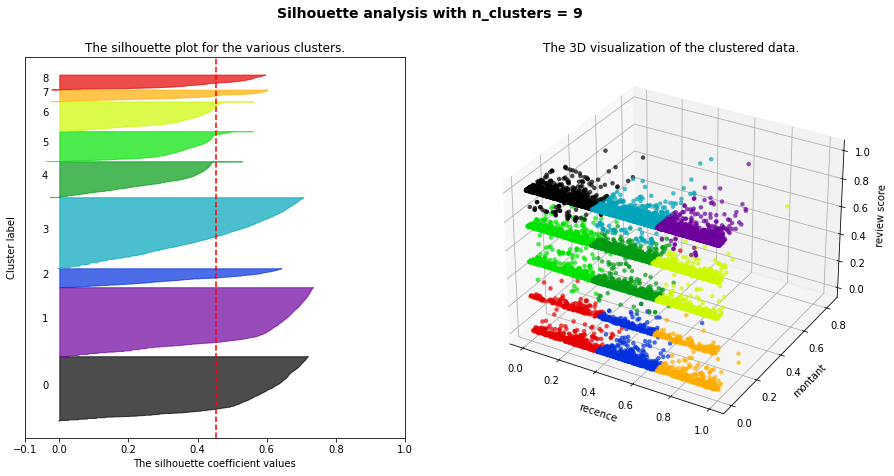

In [32]:
fitted_model = plot_silhouette(KMeans(n_clusters=9, random_state=random_seed), B0_training)

#### Affichons les moyennes des variables par cluster *(dans les échelles d'origine)*

In [33]:
get_inverse_normalization(model_scaler_B0, get_means(fitted_model, B0_training)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
5,-298.380774,170.748533,3.671532,2.463986,1.135074,1.234082
0,-297.591688,167.414002,4.993059,2.651216,1.109789,1.229003
8,-288.948428,197.461660,1.242558,2.274214,1.337526,1.426415
4,-183.283029,163.329196,3.666118,2.655352,1.150870,1.250131
2,-178.585244,190.032293,1.196577,2.164673,1.296278,1.356929
3,-175.994729,159.140327,4.994641,2.291645,1.106528,1.181603
7,-64.943639,180.165330,1.269726,2.427536,1.352657,1.371981
6,-64.519899,159.750600,3.731207,2.289482,1.144978,1.193304
1,-59.743555,165.925216,4.998010,2.087427,1.115332,1.156038


>#### On constate que:
> - les silhouettes montrent quelques points mal classés sur les groupes 4,5 et 8.
> - on a un score honorable de 0.454.

> - `cluster 7`: les clients *insatisfaits* qui ont *dépensé plus que la moyenne* et que l'on a *vu récemment*.
> - `cluster 2`: les clients *insatisfaits* qui ont *dépensé plus que la moyenne* et que l'on a *vu il y a un certain temps*.
> - `cluster 8`: les clients *insatisfaits* qui ont *dépensé plus que la moyenne* et que l'on a *vu il y a longtemps*.
><br><br>
> - `cluster 6`: les clients *modérément satisfaits* qui ont *dépensé moins que la moyenne* et que l'on a *vu récemment*.
> - `cluster 4`: les clients *modérément satisfaits* et que l'on a *vu il y a un certain temps*.
> - `cluster 5`: les clients *modérément satisfaits* et que l'on a *vu il y a longtemps*.
><br><br>
> - `cluster 1`: les clients *satisfaits* et que l'on a *vu récemment*.
> - `cluster 3`: les clients *satisfaits* qui ont *dépensé moins que la moyenne* et que l'on a *vu il y a un certain temps*.
> - `cluster 0`: les clients *satisfaits* et que l'on a *vu il y a longtemps*.
>
> Ce découpage est plutôt intéressant aussi.

#### Affichons un parallel plot des centroids

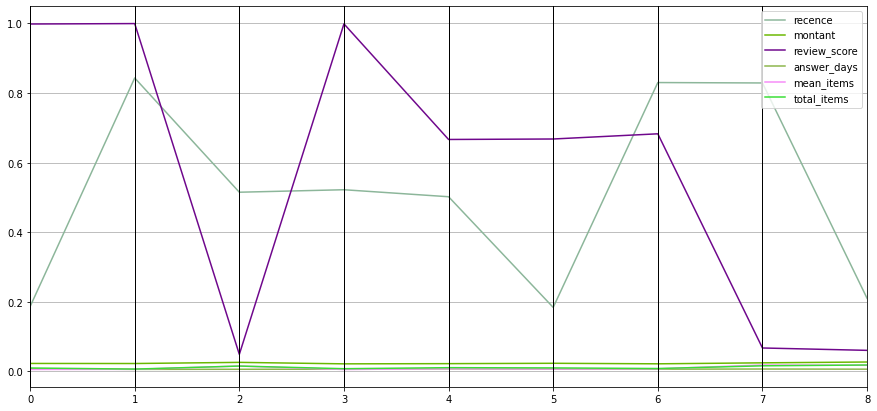

In [34]:
fig = plt.figure(figsize=(15, 7))
centroids = pd.DataFrame(fitted_model.cluster_centers_.T, index=B0_training.columns).reset_index()
pd.plotting.parallel_coordinates(centroids, class_column='index')
plt.show()

>#### On constate que sur ce modèle, ce sont principalement la `recence` et le `review_score` qui aident à déterminer les clusters...
>Les autres variables n'ont qu'une influence à la marge.